<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch4_AdaptiveIntegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adaptive Integration

We'll show the divide-and-conquer scheme that adds nodes where they are needed

This is based off section 5.7 in [*Fundamentals of Numerical Computation*](https://tobydriscoll.net/project/fnc/) by Driscoll and Braun (2018, SIAM).

Here are their [core routines for differentiation and integration (ch 5)](https://github.com/tobydriscoll/fnc-extras/blob/master/python/FNC05.py) as well as their [jupyter notebook with demos](https://github.com/tobydriscoll/fnc-extras/blob/master/python/Chapter05.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tobydriscoll/fnc-extras/blob/master/python/Chapter05.ipynb)

If you run their notebook in colab, you may need to download files, using something like:

```
!curl -O https://raw.githubusercontent.com/tobydriscoll/fnc-extras/master/python/FNC[01-13].py
!curl -O https://raw.githubusercontent.com/tobydriscoll/fnc-extras/master/python/FNC.py
```



In [62]:
import numpy as np
from scipy.integrate import quadrature

# == Plotting stuff ==
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams.update({'font.size': 20})
# This (optional) block is for improving the display of plots.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg","pdf")
mpl.rcParams["figure.figsize"] = [7,4]
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams['animation.html'] = "jshtml"  # or try "html5"

## The adaptive integration function
Based on `intadapt` from Driscoll and Braun, with very slight modifications

In [21]:
# from scipy import *
# from numpy import *
# from matplotlib.pyplot import *
# from scipy.linalg import *
# from numpy.linalg import *
# from scipy.interpolate import interp1d
# from scipy.integrate import quadrature
# import FNC

# !curl -O https://raw.githubusercontent.com/tobydriscoll/fnc-extras/master/python/FNC05.py
# from FNC05 import trapezoid
# from FNC05 import intadapt

# These functions are from Driscoll and Braun's github
# (distributed under a MIT license: 
#   https://github.com/tobydriscoll/fnc-extras/blob/master/LICENSE)
def trapezoid(f,a,b,n):
	"""
	trapezoid(f,a,b,n)
	Apply the trapezoid integration formula for integrand `f` over interval 
  [`a`,`b`], broken up into `n` equal pieces. Returns estimate, vector of nodes, 
  and vector of integrand values at the nodes.
	"""
	h = (b-a)/n
	t = np.linspace(a,b,n+1)
	y = f(t)
	T = h * ( np.sum(y[1:-1]) + 0.5*(y[0] + y[-1]) )

	return T,t,y

def intadapt(f,a,b,tol):
  """
  intadapt(f,a,b,tol)
  Do adaptive integration to estimate the integral of `f` over [`a`,`b`] to desired
  error tolerance `tol`. Returns estimate and a vector of evaluation nodes used.
  """
    # Use error estimation and recursive bisection.
  def do_integral(a,fa,b,fb,m,fm,tol):
    # These are the two new nodes and their f-values.
    xl = (a+m)/2;  fl = f(xl)
    xr = (m+b)/2;  fr = f(xr)
    t = np.array([a,xl,m,xr,b])             # all 5 nodes at this level

    # Compute the trapezoid values iteratively.
    # h = (b-a)
    # T = np.array([0.,0.,0.])
    # T[0] = h*(fa+fb)/2
    # T[1] = T[0]/2 + (h/2)*fm
    # T[2] = T[1]/2 + (h/4)*(fl+fr)
    # S = (4*T[1:]-T[:-1]) / 3      # Simpson values

    # Direct computation of Simpson's, since we're more familiar with that
    S = np.array([0.,0.])
    h    = (b-a)/2
    S[0] = h/3*( fa + 4*fm + fb )
    S[1] = h/(2*3)*( fa + 4*fl + 2*fm + 4*fr + fb )

    E = (S[1]-S[0]) / 15           # error estimate

    if abs(E) < tol*(1+abs(S[1])):  # acceptable error?
      Q = S[1]                    # yes--done
    else:
      # Error is too large--bisect and recurse.
      QL,tL = do_integral(a,fa,m,fm,xl,fl,tol)
      QR,tR = do_integral(m,fm,b,fb,xr,fr,tol)
      Q = QL + QR
      t = np.hstack([tL,tR[1:]])    # merge the nodes w/o duplicate
    return Q,t

  m = (b+a)/2
  Q,t = do_integral(a,f(a),b,f(b),m,f(m),tol)
  return Q,t

## Example 5.7.1 and 5.7.2 from Driscoll and Braun
The function $f$ is increasingly oscillatory near the right endpoint

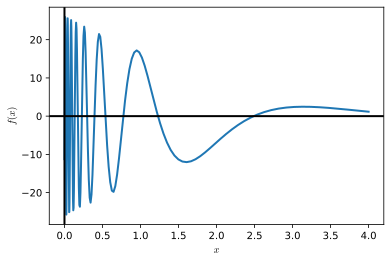

In [56]:
g = lambda x: (x+1)**2*np.cos((2*x+1)/(x-4.3))
#f = g
f = lambda x: g(4.1-x) # transform it if we want
a,b = 0,4
#x = np.linspace(a,b,600)
x = np.logspace(-7,np.log10(b),500)
plt.plot(x,f(x))
plt.xlabel("$x$"); plt.ylabel("$f(x)$");
plt.axvline(color='k');
plt.axhline(color='k');

Hence, as we'd expect, the trapezoidal rule is more accurate on the right half than on the left half

In [36]:
N = 50*2**np.arange(4)  # 50, 100, 200, 400
Tleft = np.zeros(4); Tright = np.zeros(4);
for (i,n) in enumerate(N):
    Tleft[i] = trapezoid(f,a,(a+b)/2,n)[0] 
    Tright[i] = trapezoid(f,(a+b)/2,b,n)[0] 
print("left half:",Tleft)
print("right half:",Tright)

left half: [-3.50037498 -4.33211587 -4.45170871 -4.47670217]
right half: [1.67656079 1.67849407 1.67897733 1.67909814]


In [41]:
left_val,err = quadrature(f,a,(a+b)/2,tol=1e-13,rtol=1e-13,maxiter=200)
right_val,err = quadrature(f,(a+b)/2,b,tol=1e-13,rtol=1e-13)

print("   n      left error   right error")
for k in range(N.size):
    print(f"  {N[k]:4}    {Tleft[k]-left_val:8.3e}    {Tright[k]-right_val:8.3e}")

   n      left error   right error
    50    4.032e-01    3.732e-01
   100    -4.285e-01    3.752e-01
   200    -5.481e-01    3.757e-01
   400    -5.731e-01    3.758e-01


In [43]:
# Let's get the "true" value of the whole integral
# ("Ground truth" = using Scipy's numerical quadrature)
I,errest = quadrature(f,a,b,tol=1e-14,rtol=1e-14,maxiter=200);  # 'exact' value
print("integral:",I)

integral: -2.6002911529743336


We perform the integration and show the nodes selected underneath the curve.


number of nodes: 93


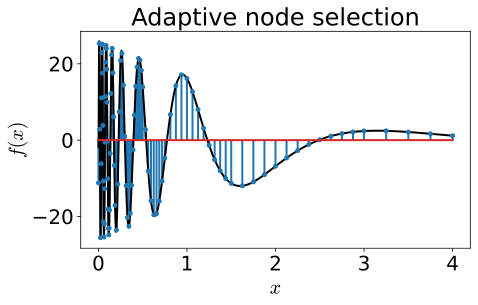

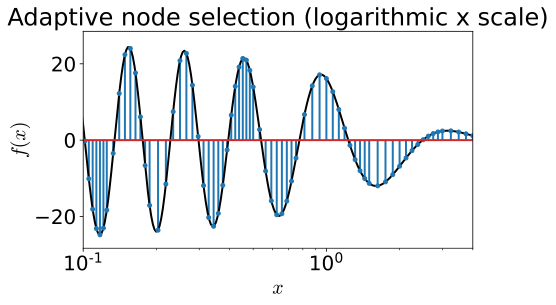

In [65]:
targetError = 1e-3
Q,t = intadapt(f,a,b,targetError)
print("number of nodes:",t.size)

#x = np.linspace(a,b,600)
x = np.logspace(-2.8,np.log10(b),500)
plt.plot(x,f(x),"k");
plt.stem(t,f(t),use_line_collection=True);
plt.xlabel("$x$"); plt.ylabel("$f(x)$"); 
plt.title("Adaptive node selection");

fig = plt.figure()
plt.plot(x,f(x),"k");
plt.stem(t,f(t),use_line_collection=True);
plt.xlabel("$x$"); plt.ylabel("$f(x)$"); 
plt.title("Adaptive node selection (logarithmic x scale)");
plt.xscale('log')
plt.xlim(1e-1,b);

The error turns out to be a bit more than we requested. It's only an estimate, not a guarantee.

In [66]:
print("Target error was {:.2e}".format(targetError))
print("Actual error was {:.2e}".format(abs(I-Q)))

Target error was 1.00e-03
Actual error was 8.66e-03


In [67]:
# Vary the tolerance
tol_ = 10.0**np.arange(-4,-15,-1) # or use np.logspace(-4,-14,11)
err_ = np.zeros(tol_.size)
num_ = np.zeros(tol_.size,dtype=int)
print("    tol         error     # f-evals")
for (i,tol) in enumerate(tol_):
    Q,t = intadapt(f,0,4,tol)
    err_[i] = I - Q
    num_[i] = t.size
    print(f"  {tol:6.1e}    {err_[i]:10.3e}    {num_[i]:6d}")

    tol         error     # f-evals
  1.0e-04    -7.841e-03       141
  1.0e-05    -4.521e-05       241
  1.0e-06    -1.885e-06       393
  1.0e-07    -1.014e-06       641
  1.0e-08     1.552e-08      1029
  1.0e-09     9.040e-09      1597
  1.0e-10    -2.136e-09      2641
  1.0e-11     2.339e-11      4169
  1.0e-12     3.127e-11      6409
  1.0e-13    -8.943e-12     10557
  1.0e-14     9.015e-14     16749


As you can see, even though the errors are not less than the estimates, the two columns decrease in tandem. If we consider now the convergence not in $h$ (which is poorly defined) but in the number of nodes actually chosen, we come close to the fourth order accuracy of the underlying Simpson scheme.

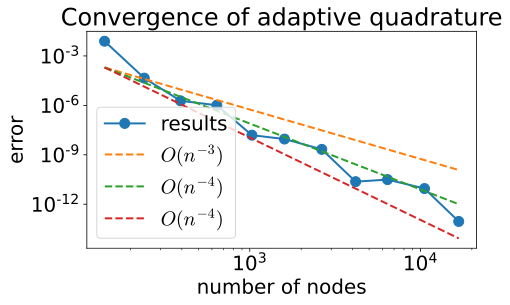

In [69]:
plt.loglog(num_,abs(err_),"-o",label="results",markersize=10)
c = 2e-4
order3 = c*(num_/num_[0])**(-3)
order4 = c*(num_/num_[0])**(-4)
order5 = c*(num_/num_[0])**(-5)
plt.loglog(num_,order3,"--",label="$O(n^{-3})$")       
plt.loglog(num_,order4,"--",label="$O(n^{-4})$")       
plt.loglog(num_,order5,"--",label="$O(n^{-4})$")       
plt.xlabel("number of nodes"); plt.ylabel("error");
plt.legend(); plt.title("Convergence of adaptive quadrature");